# Задание Ultra Lite

Перепишите сеть для генерации текста с нуля в новом ноутбуке. Можно подсматривать в ноутбук занятия, но крайне желательно писать код своими руками, а не копировать.

# Подключение библиотек

In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model

from google.colab import files
import numpy as np
import yaml

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Парсинг данных

In [3]:
# Открываем файл с диалогами
corpus = open('/content/drive/MyDrive/УИИ/Генерация текста/Диалоги.yml', 'r')
document = yaml.safe_load(corpus)
conversations = document['разговоры']
print(f'Количество пар вопрос-ответ : {len(conversations)}')
print(f'Пример диалога : {conversations[10000]}')
corpus.close()

Количество пар вопрос-ответ : 11893
Пример диалога : ['Откуда вы знаете?', 'Я  Чорин-Цу,  господин.']


In [4]:
# Разбираем вопросы-ответы с проставлением тегов ответам
questions = []
answers   = []

for con in conversations[:len(conversations)//2]:   # Из-за нехватки памяти пришлось сократить обучающий набор пополам
  if len(con) > 2:
    questions.append(con[0])
    replies = con[1:]
    ans = ''
    for rep in replies:
      ans += " " + rep
    answers.append(ans)
  elif len(con) > 1:
    questions.append(con[0])
    answers.append(con[1])

In [5]:
# Очищаем строки с неопределенным типом ответов
answersCleaned = []
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i])
  else:
    questions.pop()

In [6]:
# Сделаем теги-метки для начала и конца ответов
answers = []
for i in range(len(answersCleaned)):
  answers.append('<START>' + answersCleaned[i] + '<END>')

In [7]:
# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[5000]))
print('Ответ  : {}'.format(answers[5000]))

Вопрос : Что?..
Ответ  : <START>К Туманной Скале!<END>


In [8]:
# Подключаем керасовский токенизатор и собираем словарь индексов
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)
vocabularyItems = list(tokenizer.word_index.items())
vocabularySize = len(vocabularyItems) + 1

In [9]:
print( 'Размер словаря   : {}'.format(vocabularySize))
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:100]))

Размер словаря   : 9382
Фрагмент словаря : [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('а', 5), ('ты', 6), ('я', 7), ('это', 8), ('в', 9), ('как', 10), ('и', 11), ('да', 12), ('нет', 13), ('вы', 14), ('ну', 15), ('на', 16), ('с', 17), ('же', 18), ('где', 19), ('так', 20), ('у', 21), ('кто', 22), ('он', 23), ('то', 24), ('все', 25), ('тебя', 26), ('мы', 27), ('куда', 28), ('мне', 29), ('там', 30), ('есть', 31), ('почему', 32), ('вот', 33), ('за', 34), ('меня', 35), ('тебе', 36), ('ничего', 37), ('здесь', 38), ('еще', 39), ('знаю', 40), ('ли', 41), ('товарищ', 42), ('его', 43), ('к', 44), ('чего', 45), ('вас', 46), ('о', 47), ('надо', 48), ('зачем', 49), ('может', 50), ('вам', 51), ('сейчас', 52), ('по', 53), ('они', 54), ('нас', 55), ('можно', 56), ('чем', 57), ('тут', 58), ('бы', 59), ('но', 60), ('из', 61), ('она', 62), ('тоже', 63), ('конечно', 64), ('какой', 65), ('будет', 66), ('очень', 67), ('случилось', 68), ('уже', 69), ('дело', 70), ('сам', 71), ('сколько', 72), ('значит

# Подготовка выборки

In [10]:
# Устанавливаем закодированные входные данные(вопросы)
tokenizedQuestions = tokenizer.texts_to_sequences(questions)
maxLenQuestions = max([len(x) for x in tokenizedQuestions])

# Делаем последовательности одной длины
encoderForInput = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

In [11]:
print('Пример оригинального вопроса на вход : {}'.format(questions[1000])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[1000])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 

Пример оригинального вопроса на вход : Куда теперь?
Пример кодированного вопроса на вход : [28 82  0  0  0  0  0  0  0  0  0]
Размеры закодированного массива вопросов на вход : (5943, 11)
Установленная длина вопросов на вход : 11


In [12]:
# Устанавливаем раскодированные входные данные(ответы)
tokenizedAnswers = tokenizer.texts_to_sequences(answers)
maxLenAnswers = max([len(x) for x in tokenizedAnswers])

# Делаем последовательности одной длины
decoderForInput = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

In [13]:
print('Пример оригинального ответа на вход: {}'.format(answers[1000])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[1000])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START>На Родину!<END>
Пример раскодированного ответа на вход : [  1  16 942   2   0   0   0   0   0   0   0   0   0]
Размеры раскодированного массива ответов на вход : (5943, 13)
Установленная длина ответов на вход : 13


In [14]:
# Раскодированные выходные данные(ответы)
for i in range(len(tokenizedAnswers)):
  tokenizedAnswers[i] = tokenizedAnswers[i][1:]  # избавляемся от тега <START>

# Делаем последовательности одной длины
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

In [15]:
# переводим в one hot vector
oneHotAnswers = to_categorical(paddedAnswers, vocabularySize)
decoderForOutput = np.array(oneHotAnswers)

In [16]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[4999][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[4999][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [   1    7    4 8940  420    2    0    0    0    0    0    0    0]
Пример раскодированного ответа на выход : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (5943, 13, 9382)
Установленная длина вопросов на выход : 13


# Параметры нейросети и модель обучения

In [17]:
# Первый входной слой, кодер, выходной слой
encoderInputs = Input(shape=(None, ))
encoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True)(encoderInputs)
encoderOutputs, state_h, state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [18]:
# Второй входной слой, декодер, выходной слой
decoderInputs = Input(shape=(None, ))
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True)(decoderInputs)
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs, _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
decoderDense =  Dense(vocabularySize, activation='softmax')
output = decoderDense(decoderOutputs)

In [19]:
# Собираем тренировочную модель нейросети
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    1876400     ['input_1[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, None, 200)    1876400     ['input_3[0][0]']                
                                                                                            

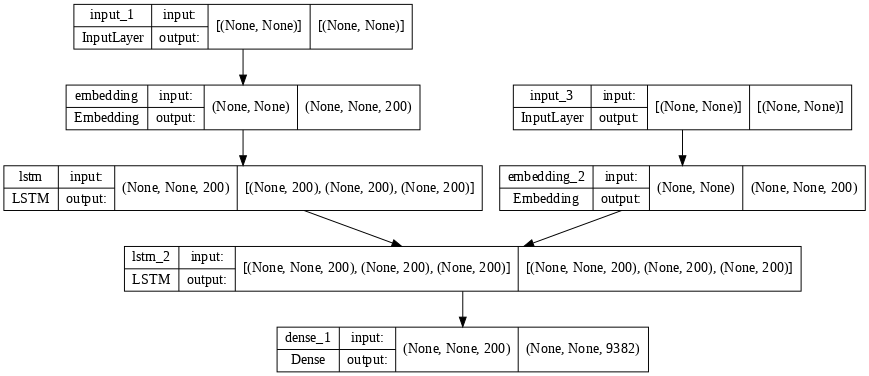

In [26]:
print(model.summary())
plot_model(model, dpi=70, show_shapes=True)

# Обучение 

In [24]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=50)

# Сохранение весов
model.save_weights('/content/drive/MyDrive/УИИ/Генерация текста/sequences_to_sequences.h5')

Epoch 1/50
119/119 [==============================] - 12s 31ms/step - loss: 0.3827
Epoch 2/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3772
Epoch 3/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3731
Epoch 4/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3704
Epoch 5/50
119/119 [==============================] - 4s 29ms/step - loss: 0.3682
Epoch 6/50
119/119 [==============================] - 3s 29ms/step - loss: 0.3666
Epoch 7/50
119/119 [==============================] - 4s 29ms/step - loss: 0.3657
Epoch 8/50
119/119 [==============================] - 4s 29ms/step - loss: 0.3651
Epoch 9/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3643
Epoch 10/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3637
Epoch 11/50
119/119 [==============================] - 4s 29ms/step - loss: 0.3638
Epoch 12/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3634
Epoch 13/50


## Дообучение

In [21]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=50)

# Сохранение весов
model.save_weights('/content/drive/MyDrive/УИИ/Генерация текста/sequences_to_sequences.h5')

Epoch 1/50
119/119 [==============================] - 15s 30ms/step - loss: 0.4258
Epoch 2/50
119/119 [==============================] - 4s 30ms/step - loss: 0.4193
Epoch 3/50
119/119 [==============================] - 4s 34ms/step - loss: 0.4153
Epoch 4/50
119/119 [==============================] - 4s 35ms/step - loss: 0.4110
Epoch 5/50
119/119 [==============================] - 4s 36ms/step - loss: 0.4086
Epoch 6/50
119/119 [==============================] - 4s 32ms/step - loss: 0.4062
Epoch 7/50
119/119 [==============================] - 4s 32ms/step - loss: 0.4049
Epoch 8/50
119/119 [==============================] - 4s 32ms/step - loss: 0.4018
Epoch 9/50
119/119 [==============================] - 4s 32ms/step - loss: 0.4009
Epoch 10/50
119/119 [==============================] - 4s 33ms/step - loss: 0.3991
Epoch 11/50
119/119 [==============================] - 4s 32ms/step - loss: 0.3984
Epoch 12/50
119/119 [==============================] - 4s 32ms/step - loss: 0.3973
Epoch 13/50


## Дообучение

In [21]:
# Запустим обучение и сохраним модель
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=50)

# Сохранение весов
model.save_weights('/content/drive/MyDrive/УИИ/Генерация текста/sequences_to_sequences.h5')

Epoch 1/50
119/119 [==============================] - 15s 30ms/step - loss: 0.3795
Epoch 2/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3715
Epoch 3/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3640
Epoch 4/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3594
Epoch 5/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3557
Epoch 6/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3513
Epoch 7/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3481
Epoch 8/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3451
Epoch 9/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3419
Epoch 10/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3399
Epoch 11/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3376
Epoch 12/50
119/119 [==============================] - 4s 30ms/step - loss: 0.3363
Epoch 13/50


# Подготовка и запуск рабочей нейросети с генерацией ответов

In [20]:
# Загрузка весов
model.load_weights('/content/drive/MyDrive/УИИ/Генерация текста/sequences_to_sequences.h5')

In [22]:
# Создаем рабочую модель для вывода ответов на запросы пользователя
def makeInferenceModels():
  encoderModel = Model(encoderInputs, encoderStates)

  decoderStateInput_h = Input(shape=(200,))
  decoderStateInput_c = Input(shape=(200,))
  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c]

  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c]
  decoderOutputs = decoderDense(decoderOutputs)

  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel, decoderModel

In [23]:
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
def strToTokens(sentence):
  words = sentence.lower().split()
  tokensList = []
  for word in words:
    tokensList.append(tokenizer.word_index[word])
  
  return pad_sequences([tokensList], maxlen = maxLenQuestions, padding='post')

In [35]:
# Устанавливаем окончательные настройки и запускаем модель 
encModel , decModel = makeInferenceModels()

for _ in range(5):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']

  stopCondition = False
  decodedTranslation = ''
  while not stopCondition :
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    sampledWordIndex = np.argmax( decOutputs[0, 0, :])
    sampledWord = None
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index:
        decodedTranslation += ' {}'.format(word)
        sampledWord = word
    
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True

    emptyTargetSeq[0, 0] = sampledWordIndex
    statesValues = [h, c]
   
  print(decodedTranslation[:-3])

Задайте вопрос : что
 ты ты 
Задайте вопрос : зачем
 а что такое 
Задайте вопрос : почему
 да так уж не знаю 
Задайте вопрос : для чего
 а ты у меня за не а ты и не ты почему не
Задайте вопрос : от чего
 я сам знаю 


# Загрузка и запуск предобученной модели

In [25]:
model = load_model('/content/drive/MyDrive/УИИ/Генерация текста/model_chatbot_100epochs(rms)+50(ada).h5')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    3020800     ['input_1[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, None, 200)    3020800     ['input_2[0][0]']                
                                                                                            

In [26]:
# Устанавливаем связи между слоями рабочей модели и предобученной
def loadInferenceModels():
  encoderInputs = model.input[0]
  encoderEmbedding = model.layers[2]
  encoderOutputs, state_h_enc, state_c_enc = model.layers[4].output
  encoderStates = [state_h_enc, state_c_enc]
  encoderModel = Model(encoderInputs, encoderStates)

  decoderInputs = model.input[1] 
  decoderStateInput_h = Input(shape=(200 ,))
  decoderStateInput_c = Input(shape=(200 ,))

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c]

  decoderEmbedding = model.layers[3]
  decoderLSTM = model.layers[5]
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding.output, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c]

  decoderDense = model.layers[6]
  decoderOutputs = decoderDense(decoderOutputs)

  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)
  return encoderModel , decoderModel

In [27]:
# Устанавливаем окончательные настройки и запускаем рабочую модель
encModel , decModel = loadInferenceModels()

for _ in range(4):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']

  stopCondition = False
  decodedTranslation = ''
  while not stopCondition :
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    sampledWordIndex = np.argmax( decOutputs[0, 0, :])
    sampledWord = None
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index:
        decodedTranslation += ' {}'.format(word)
        sampledWord = word
  
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True

    emptyTargetSeq = np.zeros((1, 1))
    emptyTargetSeq[0, 0] = sampledWordIndex
    statesValues = [h, c]
  
  print(decodedTranslation[:-3])

Задайте вопрос : что
 ли 
Задайте вопрос : зачем
 ну подсобить начал тебе 
Задайте вопрос : почему
 ты меня тебя что 
Задайте вопрос : когда
 в 


# Выводы:

1. Весь ноутбук писался в ручную, что является хорошей практикой для понимания.
2. Обучение нейронной сети происходит быстро, но требуется много памяти для такого большого массива данных. Поэтому пришлось уменьшить обучающую базу в 2 раза.
3. Для достижения более лучшего результата требуется увеличение обучающей выборке. Подбор архитекруты нейронной сети и ее гиперпараметров. 